[*********************100%%**********************]  1 of 1 completed

time window = 2023-08-22 .. 2024-07-22
2023-10-03, AMZN Close: 124.72,  RSI: 36.53, RSI-MA: 47.33, Position: 0.00, PNL: 0.00%
2023-10-04, AMZN Close: 127.00,  RSI: 41.36, RSI-MA: 46.91, Position: 0.00, PNL: 0.00%
2023-10-05, AMZN Close: 125.96,  RSI: 39.87, RSI-MA: 46.40, Position: 0.00, PNL: 0.00%
2023-10-06, AMZN Close: 127.96,  RSI: 44.05, RSI-MA: 46.24, Position: 0.00, PNL: 0.00%
2023-10-09, AMZN Close: 128.26,  RSI: 44.67, RSI-MA: 46.12, Position: 0.00, PNL: 0.00%
2023-10-10, AMZN Close: 129.48, *RSI: 47.23, RSI-MA: 46.20, Position: 0.00, PNL: 0.00%
2023-10-10, AMZN BUY CREATE, 129.48
2023-10-11, AMZN BUY EXECUTED, Price: 129.74, Cost: 5010.04, Comm 0.00
2023-10-11, AMZN Close: 131.83,  RSI: 51.86, RSI-MA: 46.61, Position: 129.74, PNL: 1.59%
2023-10-12, AMZN Close: 132.33,  RSI: 52.81, RSI-MA: 47.05, Position: 129.74, PNL: 1.96%
2023-10-13, AMZN Close: 129.79,  RSI: 47.67, RSI-MA: 47.09, Position: 129.74, PNL: 0.04%
2023-10-16, AMZN Close: 132.55,  RSI: 53.02, RSI-MA: 47.52, Posit

2024-03-20, AMZN Close: 178.15,  RSI: 59.46, RSI-MA: 60.02, Position: 129.72, PNL: 27.18%
2024-03-21, AMZN Close: 178.15,  RSI: 59.46, RSI-MA: 59.98, Position: 129.72, PNL: 27.18%
2024-03-22, AMZN Close: 178.87, *RSI: 60.58, RSI-MA: 60.03, Position: 129.72, PNL: 27.48%
2024-03-25, AMZN Close: 179.71,  RSI: 61.91, RSI-MA: 60.16, Position: 129.72, PNL: 27.82%
2024-03-26, AMZN Close: 178.30,  RSI: 58.36, RSI-MA: 60.03, Position: 129.72, PNL: 27.25%
2024-03-27, AMZN Close: 179.83, *RSI: 60.97, RSI-MA: 60.10, Position: 129.72, PNL: 27.87%
2024-03-28, AMZN Close: 180.38,  RSI: 61.90, RSI-MA: 60.23, Position: 129.72, PNL: 28.09%
2024-04-01, AMZN Close: 180.97,  RSI: 62.92, RSI-MA: 60.42, Position: 129.72, PNL: 28.32%
2024-04-02, AMZN Close: 180.69,  RSI: 62.07, RSI-MA: 60.54, Position: 129.72, PNL: 28.21%
2024-04-03, AMZN Close: 182.41,  RSI: 65.17, RSI-MA: 60.87, Position: 129.72, PNL: 28.89%
2024-04-04, AMZN Close: 180.00,  RSI: 58.02, RSI-MA: 60.66, Position: 129.72, PNL: 27.93%
2024-04-05

<IPython.core.display.Javascript object>

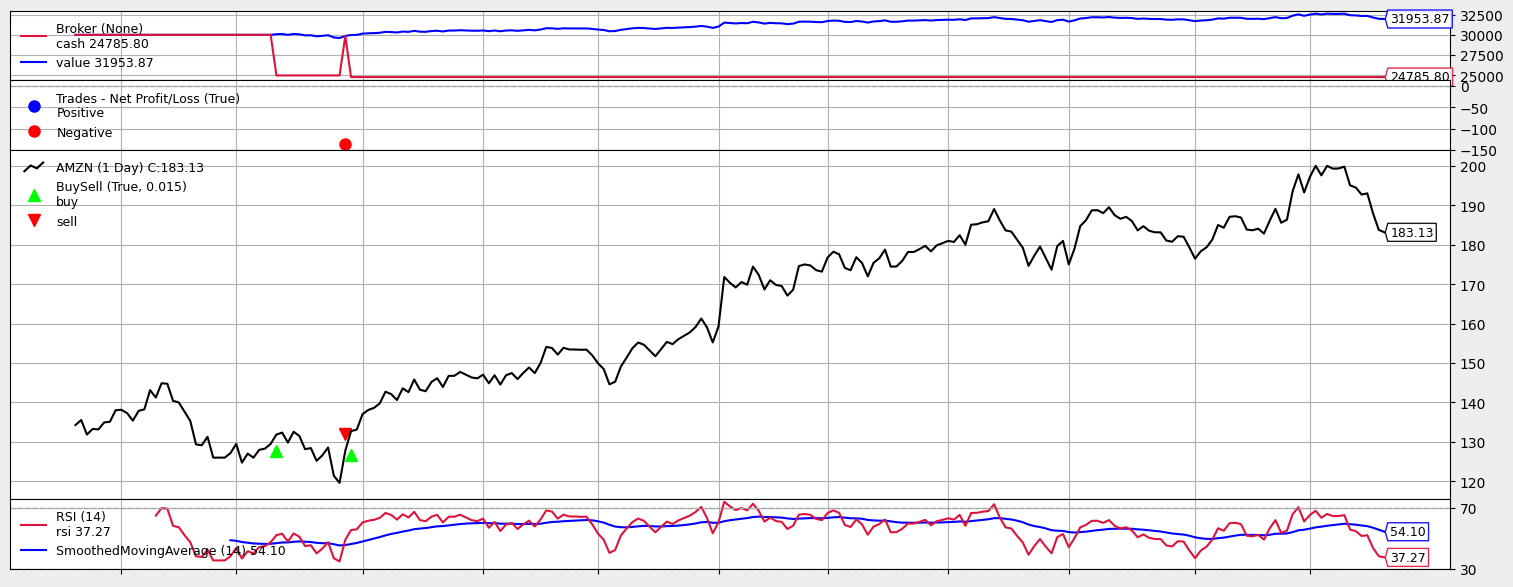

In [23]:
from api.services.backtesting_service import TestStrategy, rsi_warmup_in_days

import datetime  # For datetime objects
import backtrader as bt
import backtrader.analyzers as btanalyzers
import yfinance as yf

optimise = False
initial_cash = 30000

# strategy-controls
printlog=True
upper_rsi=60
lower_rsi=50
loss_pct_threshold = 8
profit_protection_pct_threshold = 0
fixed_investment_amount=5000

tech_stock = [ 'AMZN', 'SNOW', 'MSFT', 'AAPL', 'GOOG', 'NVDA', 'META']
tech_stock_without_snow = [s for s in tech_stock if s != 'SNOW']
tech_stock_without_nvidia = [s for s in tech_stock if s != 'NVDA']
non_tech_stock = [ 'JNJ', 'JPM', 'PFE', 'PG', 'UNH', 'V'] # FIXME: default strategy causes losses in non-tech stock
interesting_stock = tech_stock + non_tech_stock
#interesting_stock_without_nvda = interesting_stock.remove('NVDA')

num_years = 1
year_offset = 0
target_stock = ['AMZN']

num_years_in_days = 365 * num_years
year_offset_in_days = 365 * year_offset

# default behaviour: last year tech stock
number_of_days_to_simulate, time_travel_days, tickers = num_years_in_days, year_offset_in_days, target_stock

# FIXME: len(self) is broken when SNOW is in ticker set
# FIXME: Hint 1: for 2-year-ago debug TestStrategy.days_in_buffer() shows 28 in AMZN, tech_stock_without_snow, but 297 with tech_stock
# FIXME: Hint 2: for year-to-date all show 28 meaning issue likely due to SNOW not being present 2 years prior 
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, ['AMZN']
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, tech_stock_without_snow
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 2, tech_stock
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 0, tech_stock_without_snow
#number_of_days_to_simulate, time_travel_days, tickers = 365, 365 * 0, tech_stock

end_date=datetime.datetime.today().date() - datetime.timedelta(time_travel_days)
start_date = end_date - datetime.timedelta(number_of_days_to_simulate + time_travel_days - rsi_warmup_in_days)

#start_date = datetime.datetime.strptime('2024-01-01', "%Y-%m-%d").date()
#end_date = datetime.datetime.strptime('2024-12-01', "%Y-%m-%d").date()

def add_stats(rsi_lower, rsi_upper, loss_pct, profit_protection_pct_threshold, fixed_investment_amount, final_value):
    stats.append({'rsi_lower': rsi_lower, 
                  'rsi_upper': rsi_upper, 
                  'loss_pct': loss_pct,
                  'profit_protection_pct_threshold': profit_protection_pct_threshold,
                  'fixed_investment_amount': fixed_investment_amount ,
                  'final_value': final_value}) 

def strategy_completed_callback(strategy):
    final_value = strategy.broker.get_value()
    print("strategy_completed_callback stats: " + 
        f'lower_rsi: {strategy.params.lower_rsi}, ' +
        f'upper_rsi: {strategy.params.upper_rsi}, ' +
        f'loss_pct: {strategy.params.loss_pct_threshold}, ' +
        f'profit_protection_pct_threshold: {strategy.params.profit_protection_pct_threshold}, ' +
        f'fixed_investment_amount: {strategy.params.fixed_investment_amount}, ' +
        f'final Portfolio Value: {final_value:.0f}'
    )
    stats.append({'rsi_lower': strategy.params.lower_rsi, 
        'rsi_upper': strategy.params.upper_rsi, 
        'loss_pct': strategy.params.loss_pct_threshold,
        'profit_protection_pct_threshold': strategy.params.profit_protection_pct_threshold,
        'fixed_investment_amount': strategy.params.fixed_investment_amount,
        'final_value': round(strategy.broker.getvalue())}) 

stats = []

if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro(optreturn=False)

    if not optimise:
        # Add a strategy (see strategy-controls)
        cerebro.addstrategy(TestStrategy,
                            printlog = printlog,
                            upper_rsi = upper_rsi,
                            lower_rsi = lower_rsi,
                            loss_pct_threshold = loss_pct_threshold,
                            profit_protection_pct_threshold = profit_protection_pct_threshold,
                            fixed_investment_amount = fixed_investment_amount)
    else:
        strats = cerebro.optstrategy(
            TestStrategy,
            upper_rsi= 60 , # upper_rsi=range(55, 70, 5), RSI-upper down-crossing not wired
            lower_rsi = 40, # range(30, 60, 5), 
            loss_pct_threshold = 8, # range(1,15),
            profit_protection_pct_threshold = 0, #range(0, 100, 25),
            fixed_investment_amount = 5000, # range(500, 5500, 500),
            custom_callback=strategy_completed_callback,
            )
        cerebro.addanalyzer(btanalyzers.DrawDown, _name='drawdown')

    print(f"time window = {start_date} .. {end_date}")

    # Add the Data Feed to Cerebro
    for ticker in tickers:
        data = bt.feeds.PandasData(dataname=yf.download(ticker, start_date, end_date))
        cerebro.adddata(data=data, name=ticker)

    # Set our desired cash start
    cerebro.broker.setcash(initial_cash)

    # Print out the starting conditions
    start_portfolio_value = cerebro.broker.getvalue()

    # Run over everything
    opt_runs = cerebro.run(maxcpus=1)
   
    if optimise: 
        print('Optimised runs by Final Value:')
        sorted_results = sorted(stats, key=lambda x: x['final_value'], reverse=True)
        for result in sorted_results[:5]:
            print(result)
    else:
        # Print out the final result
        print(f'Portfolio Value Starting: {start_portfolio_value:.0f}, End: {cerebro.broker.getvalue():.0f}')
        print(f'Plotting graphs ...')
        # Plot the result
        %matplotlib inline
        import matplotlib.pyplot as plt
        from pylab import rcParams #Creates parameters for our plot
        rcParams['figure.figsize'] = 16, 6 * len(tickers) #size
        rcParams['figure.facecolor'] = '#eeeeee' #Color scheme
        plt.plot() #The Plot Code
        plt.close()
        cerebro.plot(iplot=True, volume=False)